TensorFlow Version: 2.20.0
Found 35 datasets. Loading...
  - Loaded 551_Charge2_processed.csv
  - Loaded 551_Charge6_processed.csv
  - Loaded 551_Charge1_processed.csv
  - Loaded 551_Charge5_processed.csv
  - Loaded 552_PausCycl_processed.csv
  - Loaded 552_Charge9_processed.csv
  - Loaded 552_Charge10_processed.csv
  - Loaded 552_Mixed7_processed.csv
  - Loaded 552_Cap_1C_processed.csv
  - Loaded 549_Dis_2C_processed.csv
  - Loaded 552_Mixed3_processed.csv
  - Loaded 552_Charge14_processed.csv
  - Loaded 549_HPPC_processed.csv
  - Loaded 551_Mixed2_processed.csv
  - Loaded 551_US06_processed.csv
  - Loaded 551_Charge8_processed.csv
  - Loaded 551_Mixed1_processed.csv
  - Loaded 552_Mixed4_processed.csv
  - Loaded 552_Charge13_processed.csv
  - Loaded 552_Charge16_processed.csv
  - Loaded 552_Charge12_processed.csv
  - Loaded 552_Mixed5_processed.csv
  - Loaded 552_Charge15_processed.csv
  - Loaded 549_C20DisCh_processed.csv
  - Loaded 552_Mixed6_processed.csv
  - Loaded 552_Charge11_p

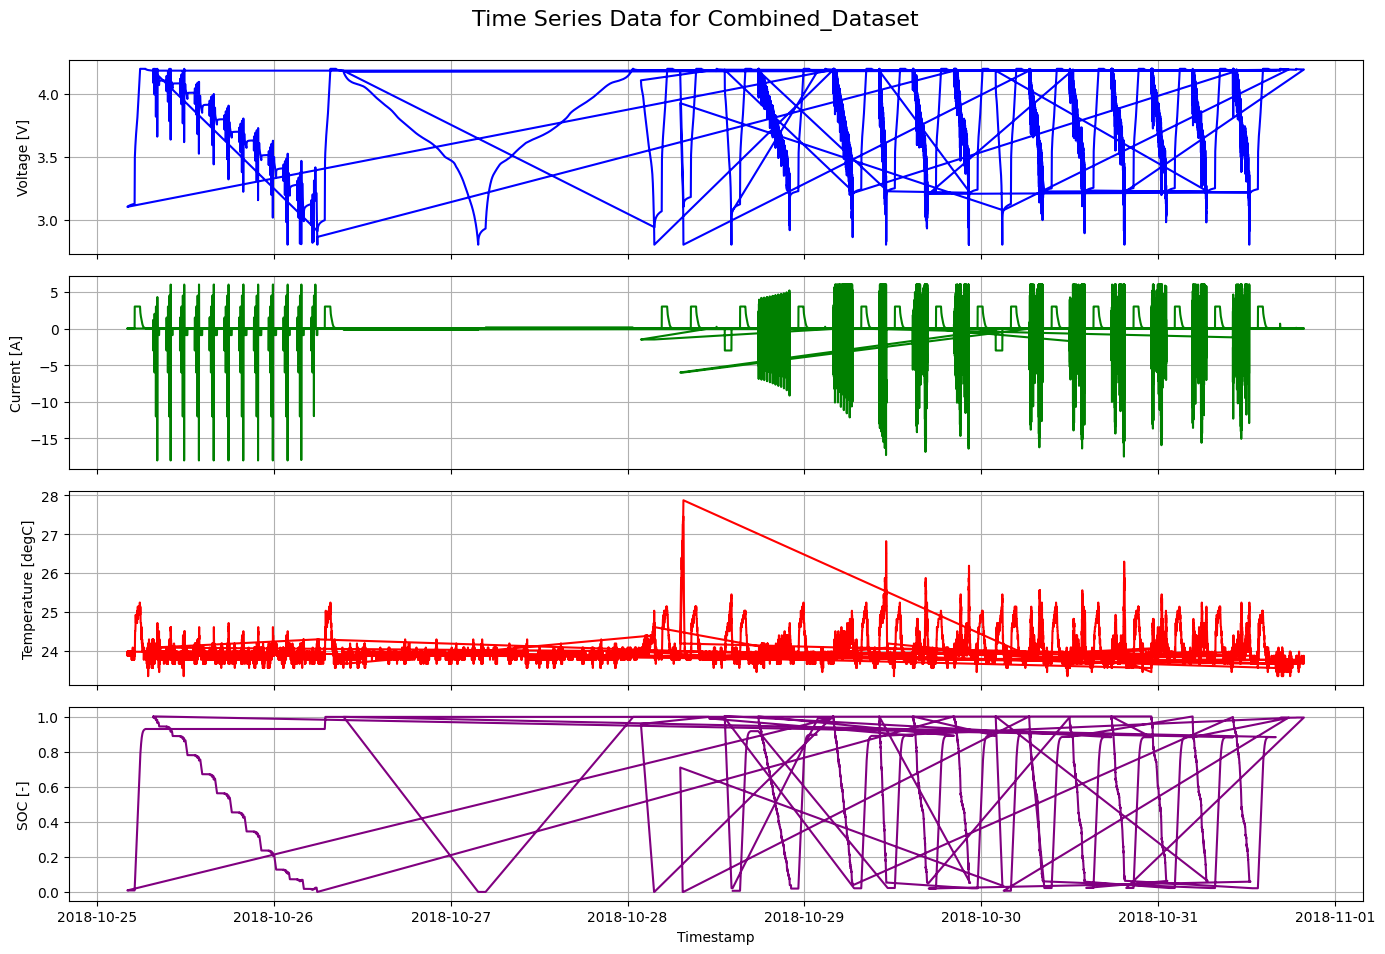


Processing: Combined_Dataset
1. Preprocessing data...

2. Building selected model(s)...

--- LSTM Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,301 (126.18 KB)

 Trainable params: 32,301 (126.18 KB)

 Non-trainable params: 0 (0.00 B)


3. Training and evaluating model(s)...

--- Training LSTM Model ---
Epoch 1/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0224 - mae: 0.0672 - val_loss: 0.0121 - val_mae: 0.0333
Epoch 2/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0015 - mae: 0.0222 - val_loss: 0.0124 - val_mae: 0.0346
Epoch 3/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0013 - mae: 0.0216 - val_loss: 0.0119 - val_mae: 0.0322
Epoch 4/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0011 - mae: 0.0203 - val_loss: 0.0123 - val_mae: 0.0387
Epoch 5/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0011 - mae: 0.0206 - val_loss: 0.0122 - val_mae: 0.0350
Epoch 6/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.8260e-04 - mae: 0.0196 - val_loss: 0.0118 - val_mae: 0.0326
Epoch 7/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 9.1049e-04 - mae: 0.0188 - val_loss: 0.0119 - val_mae: 0.0329
Epoch 8/50
1193/1193 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 8.1672e-04 - mae: 0.0

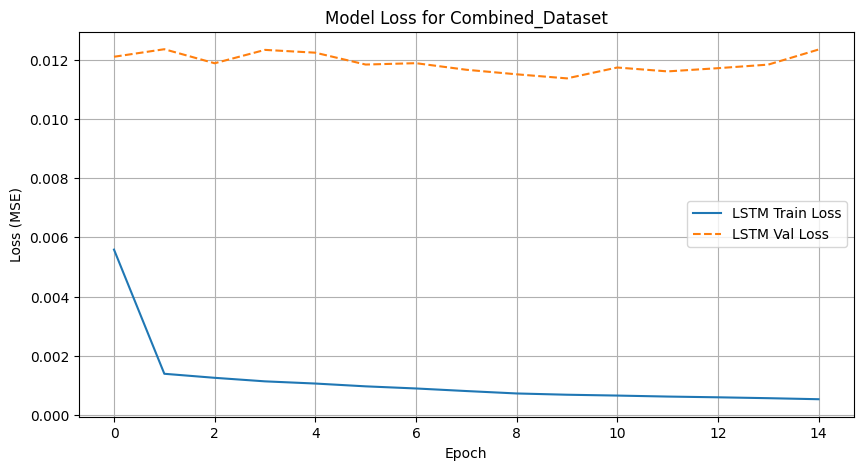

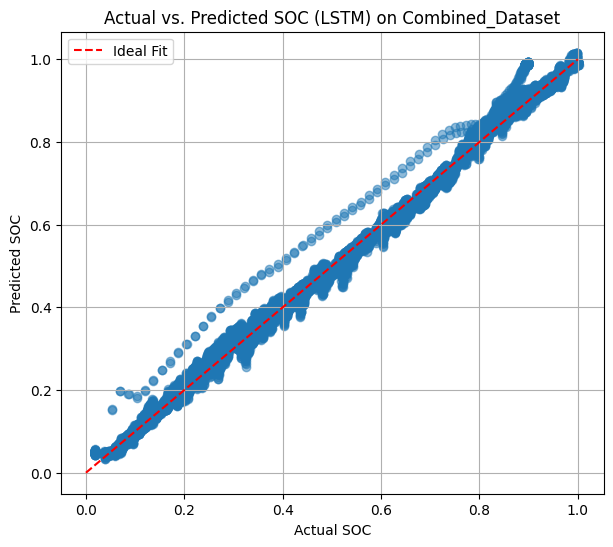


--- Finished processing Combined_Dataset ---


In [1]:
# -*- coding: utf-8 -*-
"""
Battery SOC Estimation using Deep Learning (Local & Selective Version)

This script allows for selective training of a single model (ANN, CNN, or LSTM)
to save time and computational resources.
"""

# ==============================================================================
# 1. SETUP AND IMPORTS
# ==============================================================================
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import glob

print("TensorFlow Version:", tf.__version__)

# ==============================================================================
# 2. CONFIGURATION AND DATA LOADING
# ==============================================================================

# --- Main Configuration ---

# CHOOSE WHICH MODEL TO RUN:
# Options: 'ann', 'cnn', 'lstm', or 'all'
MODEL_TO_RUN = 'lstm'

# Set to True to combine all datasets, False to process them one by one.
COMBINE_DATASETS = True

# Path to the folder containing your dataset(s).
DATA_PATH = 'data'

# --- Model Hyperparameters ---
LOOK_BACK = 10
N_EPOCHS = 50
BATCH_SIZE = 64

# --- Data Loading Function (unchanged) ---
def load_data(data_path, combine_files=False):
    csv_files = glob.glob(os.path.join(data_path, '*.csv'))
    if not csv_files:
        print(f"Error: No CSV files found in the '{data_path}' directory.")
        return None, []

    all_dfs = []
    print(f"Found {len(csv_files)} datasets. Loading...")
    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            all_dfs.append(df)
            print(f"  - Loaded {os.path.basename(file_path)}")
        except Exception as e:
            print(f"  - Error loading {os.path.basename(file_path)}: {e}")

    if not all_dfs:
        return None, []

    if combine_files and len(all_dfs) > 1:
        print("\nCombining all datasets into a single DataFrame.")
        combined_df = pd.concat(all_dfs, ignore_index=True)
        return [combined_df], ['Combined_Dataset']
    else:
        file_names = [os.path.basename(f) for f in csv_files]
        return all_dfs, file_names

# ==============================================================================
# 3. HELPER FUNCTIONS (UNCHANGED)
# (EDA, Preprocessing, Model Building, Training, Plotting)
# ==============================================================================

def perform_eda(df, dataset_name="Dataset"):
    if df.empty:
        print("DataFrame is empty. Skipping EDA.")
        return
    print(f"\n--- EDA for {dataset_name} ---")
    fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
    fig.suptitle(f'Time Series Data for {dataset_name}', fontsize=16)
    axes[0].plot(df['Timestamp'], df['Voltage [V]'], color='blue')
    axes[0].set_ylabel('Voltage [V]'); axes[0].grid(True)
    axes[1].plot(df['Timestamp'], df['Current [A]'], color='green')
    axes[1].set_ylabel('Current [A]'); axes[1].grid(True)
    axes[2].plot(df['Timestamp'], df['Temperature [degC]'], color='red')
    axes[2].set_ylabel('Temperature [degC]'); axes[2].grid(True)
    axes[3].plot(df['Timestamp'], df['SOC [-]'], color='purple')
    axes[3].set_ylabel('SOC [-]'); axes[3].set_xlabel('Timestamp'); axes[3].grid(True)
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]); plt.show()

def preprocess_data(df, look_back):
    features = df[['Voltage [V]', 'Current [A]', 'Temperature [degC]']].values
    target = df[['SOC [-]']].values
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    features_scaled = scaler_features.fit_transform(features)
    target_scaled = scaler_target.fit_transform(target)
    train_size = int(len(features_scaled) * 0.8)
    train_features, test_features = features_scaled[:train_size], features_scaled[train_size:]
    train_target, test_target = target_scaled[:train_size], target_scaled[train_size:]
    X_train_ann, y_train_ann = train_features, train_target
    X_test_ann, y_test_ann = test_features, test_target
    def create_sequences(features, target, look_back):
        X, y = [], []
        for i in range(len(features) - look_back):
            X.append(features[i:(i + look_back)])
            y.append(target[i + look_back])
        return np.array(X), np.array(y)
    X_train_seq, y_train_seq = create_sequences(train_features, train_target, look_back)
    X_test_seq, y_test_seq = create_sequences(test_features, test_target, look_back)
    return {
        'ann': (X_train_ann, y_train_ann, X_test_ann, y_test_ann),
        'seq': (X_train_seq, y_train_seq, X_test_seq, y_test_seq),
        'scalers': {'features': scaler_features, 'target': scaler_target}
    }

def build_ann(input_shape):
    model = Sequential([Input(shape=input_shape), Dense(64, activation='relu'), Dense(32, activation='relu'), Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def build_cnn(input_shape):
    model = Sequential([Input(shape=input_shape), Conv1D(filters=64, kernel_size=3, activation='relu'), MaxPooling1D(pool_size=2), Flatten(), Dense(50, activation='relu'), Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def build_lstm(input_shape):
    model = Sequential([Input(shape=input_shape), LSTM(50, return_sequences=True), LSTM(50), Dense(25, activation='relu'), Dense(1)])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

def train_and_evaluate(models, data_dict):
    results = {}
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    for name, model in models.items():
        print(f"\n--- Training {name.upper()} Model ---")
        X_train, y_train, X_test, y_test = data_dict['ann'] if name == 'ann' else data_dict['seq']
        history = model.fit(X_train, y_train, epochs=N_EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[early_stop], verbose=1)
        y_pred_scaled = model.predict(X_test)
        scaler_target = data_dict['scalers']['target']
        y_pred = scaler_target.inverse_transform(y_pred_scaled)
        y_test_orig = scaler_target.inverse_transform(y_test.reshape(-1, 1))
        results[name] = {
            'history': history, 'y_test': y_test_orig, 'y_pred': y_pred,
            'metrics': {'MAE': mean_absolute_error(y_test_orig, y_pred), 'RMSE': np.sqrt(mean_squared_error(y_test_orig, y_pred)), 'R²': r2_score(y_test_orig, y_pred)}
        }
        print(f"\n{name.upper()} Model Evaluation: MAE: {results[name]['metrics']['MAE']:.4f}, RMSE: {results[name]['metrics']['RMSE']:.4f}, R²: {results[name]['metrics']['R²']:.4f}")
    return results

def plot_results(results, dataset_name):
    num_models = len(results)
    if num_models == 0:
        return
    
    # Plot Learning Curves
    plt.figure(figsize=(10, 5))
    for name, result in results.items():
        plt.plot(result['history'].history['loss'], label=f'{name.upper()} Train Loss')
        plt.plot(result['history'].history['val_loss'], linestyle='--', label=f'{name.upper()} Val Loss')
    plt.title(f'Model Loss for {dataset_name}'); plt.xlabel('Epoch'); plt.ylabel('Loss (MSE)'); plt.legend(); plt.grid(True); plt.show()

    # Plot Actual vs Predicted
    fig, ax = plt.subplots(1, 1, figsize=(7, 6))
    model_name = list(results.keys())[0]
    result = results[model_name]
    ax.scatter(result['y_test'], result['y_pred'], alpha=0.5)
    ax.plot([0, 1], [0, 1], 'r--', label='Ideal Fit')
    ax.set_title(f'Actual vs. Predicted SOC ({model_name.upper()}) on {dataset_name}'); ax.set_xlabel('Actual SOC'); ax.set_ylabel('Predicted SOC'); ax.grid(True); ax.legend()
    plt.show()

# ==============================================================================
# 4. MAIN EXECUTION PIPELINE
# ==============================================================================
def main():
    datasets, dataset_names = load_data(DATA_PATH, COMBINE_DATASETS)
    if not datasets:
        print("Execution stopped because no datasets were loaded.")
        return

    # Perform EDA on the first (or combined) dataset
    perform_eda(datasets[0], dataset_names[0])

    for i, df in enumerate(datasets):
        dataset_name = dataset_names[i]
        print(f"\n{'='*60}\nProcessing: {dataset_name}\n{'='*60}")

        print("1. Preprocessing data...")
        data_dict = preprocess_data(df, LOOK_BACK)

        print("\n2. Building selected model(s)...")
        input_shape_ann = (data_dict['ann'][0].shape[1],)
        input_shape_seq = (data_dict['seq'][0].shape[1], data_dict['seq'][0].shape[2])
        
        models = {}
        model_choice = MODEL_TO_RUN.lower()

        if model_choice == 'ann':
            models['ann'] = build_ann(input_shape_ann)
        elif model_choice == 'cnn':
            models['cnn'] = build_cnn(input_shape_seq)
        elif model_choice == 'lstm':
            models['lstm'] = build_lstm(input_shape_seq)
        elif model_choice == 'all':
            models['ann'] = build_ann(input_shape_ann)
            models['cnn'] = build_cnn(input_shape_seq)
            models['lstm'] = build_lstm(input_shape_seq)
        else:
            print(f"Error: Invalid model choice '{MODEL_TO_RUN}'. Please choose 'ann', 'cnn', 'lstm', or 'all'.")
            return

        if not models:
            print("No models were built. Exiting.")
            return
            
        # Display summary for the built model(s)
        for name, model in models.items():
            print(f"\n--- {name.upper()} Model Summary ---")
            model.summary()

        print("\n3. Training and evaluating model(s)...")
        results = train_and_evaluate(models, data_dict)

        if results:
            print("\n4. Visualizing results...")
            plot_results(results, dataset_name)
        
        print(f"\n--- Finished processing {dataset_name} ---")

if __name__ == "__main__":
    main()
